# Identificacion de cancer metastasico en imagenes de exploraciones patologicas

In [24]:
#!/usr/bin/env python3

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import SeparableConv2D, Conv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import sys
import shutil
from sklearn.model_selection import train_test_split
import os
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
import cv2
import seaborn as sns
from random import shuffle


Se crea una funcion con el modelo a usar

In [26]:

def Histopatologia(ancho, alto, profundidad, clases):
    """
    Modelo de deteccion de Histopatologia.

    Se crea un posible modelo aplicanndo 2 convoluciones y al final
    se realizara un flat para el cubo formado linearize
    Se usa un derivado de la red LeNet5
    
    en la cual se observa dos capas convolucionales 
    
    """
    model = Sequential()
    chanDim = -1
    # CONV 1
    model.add(Conv2D(32, (3, 3), padding="same", activation='relu',
                     input_shape=(alto, ancho, profundidad)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # (CONV 2)
    model.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # aplanado de la imagen
    model.add(Flatten())
    model.add(Dense(256, activation="relu"))
    model.add(BatchNormalization())

    # softmax classifier
    model.add(Dense(clases, activation="softmax"))
    model.summary()

    # return the constructed network architecture
    return model


En este proyecto se usara el dataset de train_label para el entrenamiento y la validacion

In [27]:

df = pd.read_csv('./train_labels.csv')
"""
Leyendo los avances en Kaggle se observo que estas dos imagenes
causan problemas en el entrenamiento

"""
df = df[df['id'] != 'dd6dfed324f9fcb6f93f46f32fc800f2ec196be2'] 
df = df[df['id'] != '9369c7278ec8bcc6c880d99194de09fc2bd4efbe']

df_0 = df[df['label'] == 0]
df_1 = df[df['label'] == 1]

df_train = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)

df_train

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,755db6279dae599ebb4d39a9123cce439965282d,0
2,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
3,068aba587a4950175d04c680d38943fd488d6a9d,0
4,acfe80838488fae3c89bd21ade75be5c34e66be7,0
...,...,...
220018,8a25b1632a1859d7b757e912ca673385b64e1b1d,1
220019,3e24dd48c3a419f4d669cac3cf71e777ba100541,1
220020,309210db7f424edbc22b2d13bf2fa27518b18f5c,1
220021,d4b854fe38b07fe2831ad73892b3cec877689576,1


In [28]:
"""
Las imagenes de train se dividiran en grupo de entranamiento y validadcion.
"""
df_train, df_valid = train_test_split(df_train,
                                      train_size=0.9,
                                      random_state=0)

y_train = df_train['label'].values
x_train_id = df_train['id'].values
y_valid = df_valid['label'].values
x_valid_id = df_valid['id'].values

Se crea un archivo con extension '.npy' donde se guarda las matrices de las imagenes de entrenamiento y validacion

In [29]:
"""
Se cortara la imagen central de 32x32 para el entranamiento
"""
# se guarda el archivo x_train y si existe lo carga

if os.path.exists('X_train.npy'):
    X_train = np.load('X_train.npy')
    print("Se cargo el archivo X_train.npy")
else:
    X_train = []
    for j, i in enumerate(x_train_id):
        sys.stdout.write("lectura de df_train: %d%%\r" % (j*100//len(x_train_id)))
        sys.stdout.flush()
        a = cv2.imread('./train/{}.tif'.format(i))  # se lee las imagenes
        b = a[31:31+32, 31:31+32]  # se corta la imagen a 32 x 32 x 3
        X_train.append(b)
    print("lectura de df_train: %d%%   \r" % (j*100//len(x_train_id)+1))
    X_train = np.array(X_train)
    np.save('X_train.npy', X_train)

# se guarda el archivo x_valid y si existe lo carga
    
if os.path.exists('X_valid.npy'):
    X_valid = np.load('X_valid.npy')
    print("Se cargo el archivo X_valid.npy")
else:
    X_valid = []
    for j, i in enumerate(x_valid_id):
        sys.stdout.write("lectura de df_valid: %d%%\r" % (j*100//len(x_valid_id)))
        sys.stdout.flush()
        a = cv2.imread('./train/{}.tif'.format(i))  # se lee las imagenes
        b = a[31:31+32, 31:31+32]  # se corta la imagen a 32 x 32 x 3
        X_valid.append(b)
    print("lectura de df_valid: %d%%   \r" % (j*100//len(x_valid_id)+1))
    X_valid = np.array(X_valid)
    np.save('X_valid.npy', X_valid)

Se cargo el archivo X_train.npy
Se cargo el archivo X_valid.npy


Como keras solo usa datos de  categoria se tiene q convertir los labels 0 , 1 a [1,0] , [0,1]

In [30]:
"""
SE ajustara los datos, y_train a categorical

"""

y_train = to_categorical(y_train, num_classes=2)
y_valid = to_categorical(y_valid, num_classes=2)

"""
como las imagens usan valores de 0 a 255,se normaliza con una funcion
proveniente de keras llamada 'ImageDataGenerator'y se austa los datos 
de x_train y x_valid a esta 
"""
datagen = ImageDataGenerator(rescale=1.0/255)
datagen.fit(X_train)
X_y_train = datagen.flow(X_train, y_train, batch_size=32)
X_y_valid = datagen.flow(X_valid, y_valid, batch_size=32)
X_y_train

Se llama el modelo para compilarlo 

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               1048832   
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)              

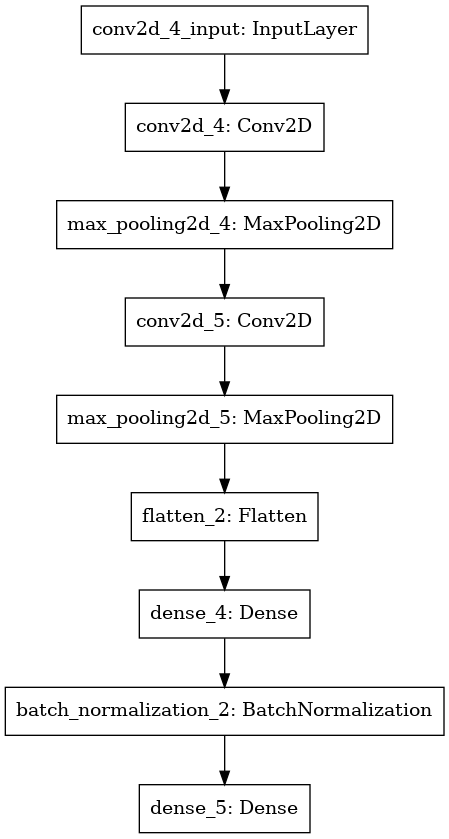

In [31]:

modelo = Histopatologia(32, 32, 3, 2)

modelo.compile(optimizer=Adam(lr=0.0001), # el optimizador usado es el algoritmo Adam 
              loss='binary_crossentropy', # como son dos clases de salida se usa binary crossentropy 
              metrics=['accuracy']) # la metria a usar es la exactitud 
plot_model(modelo, to_file='model.png') # imprime como un lista de los algoritmos usados en el modelo 



En la siguiente parte se entrena el modelo junto con otros detalles, 
la funcion ModelCheckpoint guarda el mejor modelo de cada epoca 

In [32]:
train_steps = np.ceil(len(y_train) / 32)
val_steps = np.ceil(len(y_valid) / 32)
filepath = "checkpoint.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1,
                             save_best_only=True, mode='max')  # Save Best Epoc

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2,
                              verbose=1, mode='max', min_lr=0.00001)
callbacks_list = [checkpoint, reduce_lr] 

history = modelo.fit_generator(X_y_train, steps_per_epoch=train_steps,
                              validation_data=X_y_valid,
                              validation_steps=val_steps,
                              epochs=11,
                              verbose=1,
                              callbacks=callbacks_list)

Epoch 1/11
6189/6189 [==============================] - 25s 4ms/step - loss: 0.4879 - accuracy: 0.7744 - val_loss: 0.4621 - val_accuracy: 0.7940 - lr: 1.0000e-04
Epoch 2/11
6189/6189 [==============================] - 26s 4ms/step - loss: 0.4519 - accuracy: 0.7971 - val_loss: 0.5287 - val_accuracy: 0.7452 - lr: 1.0000e-04
Epoch 3/11
6189/6189 [==============================] - 25s 4ms/step - loss: 0.4347 - accuracy: 0.8061 - val_loss: 0.4454 - val_accuracy: 0.7970 - lr: 1.0000e-04
Epoch 4/11
6189/6189 [==============================] - 25s 4ms/step - loss: 0.4238 - accuracy: 0.8123 - val_loss: 0.4436 - val_accuracy: 0.7953 - lr: 1.0000e-04
Epoch 5/11
6189/6189 [==============================] - 25s 4ms/step - loss: 0.4146 - accuracy: 0.8171 - val_loss: 0.4201 - val_accuracy: 0.8153 - lr: 1.0000e-04
Epoch 6/11
6189/6189 [==============================] - 26s 4ms/step - loss: 0.4062 - accuracy: 0.8206 - val_loss: 0.4272 - val_accuracy: 0.8109 - lr: 1.0000e-04
Epoch 7/11
6189/6189 [======

In [34]:
history.history

{'loss': [0.4879157841205597,
  0.45189493894577026,
  0.4346991777420044,
  0.423831045627594,
  0.41463232040405273,
  0.40621209144592285,
  0.3989708721637726,
  0.3910748362541199,
  0.3843567669391632,
  0.3774419128894806,
  0.3709219992160797],
 'accuracy': [0.7743813991546631,
  0.7970760464668274,
  0.806065022945404,
  0.81229168176651,
  0.8171043395996094,
  0.8205888271331787,
  0.8240379691123962,
  0.8287748694419861,
  0.8310221433639526,
  0.835860013961792,
  0.8384102582931519],
 'val_loss': [0.4621477425098419,
  0.5286567807197571,
  0.44537198543548584,
  0.44363877177238464,
  0.42010754346847534,
  0.42721083760261536,
  0.4337749779224396,
  0.43800219893455505,
  0.4206755757331848,
  0.47930610179901123,
  0.4154549241065979],
 'val_accuracy': [0.7939826250076294,
  0.7452165484428406,
  0.7969822287559509,
  0.795255184173584,
  0.8152979016304016,
  0.8109349012374878,
  0.7999363541603088,
  0.8108440041542053,
  0.8147525191307068,
  0.7960732579231262,


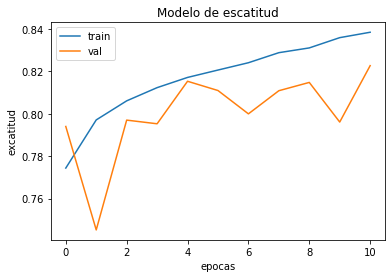

In [35]:
# Plot de accuracu entrenamiento validacion 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Modelo de escatitud')
plt.ylabel('excatitud')
plt.xlabel('epocas')
plt.legend(['train', 'val'], loc='best')
plt.show()



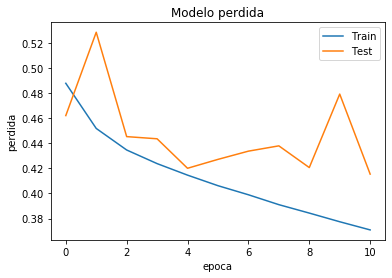

In [37]:
# Plot valores de perdida train y validation 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Modelo perdida')
plt.ylabel('perdida')
plt.xlabel('epoca')
plt.legend(['Train', 'Test'], loc='best')
plt.show()